# Annotation Error Detection
## IMD3011 - Datacentric AI
### [Dr. Elias Jacob de Menezes Neto](https://docente.ufrn.br/elias.jacob)


> Parts of this notebook were adapted from the amazing [MIT Introduction to Data-Centric AI](https://dcai.csail.mit.edu) course taugh by the amazing folks from [Cleanlab](https://cleanlab.ai/)

## Keypoints

- **Annotation Error Detection (AED):** AED is a systematic process for identifying mislabeled or inconsistent examples in datasets. It employs two primary approaches: binary flaggers (which mark potential errors) and scorers (which assign confidence scores indicating the likelihood of error). These techniques are essential for ensuring high-quality training data.

- **Types of Label Noise:** Label noise manifests in three distinct patterns:
  - **Uniform (Symmetric) Noise:** Every incorrect label is equally likely regardless of the true class
  - **Systematic (Asymmetric) Noise:** Specific classes are consistently confused with other particular classes
  - **Instance-Dependent Noise:** The probability of mislabeling varies based on the specific features of each instance

- **Label Noise Transition Matrix:** This matrix represents the conditional probability p(ỹ=i|y*=j) that an instance with true label j is observed as label i. It provides a mathematical framework for understanding noise patterns and forms the foundation for methods like Confident Learning that adjust for label noise during training.

- **Causes of Label Noise:** Noisy labels stem from various sources including human error (fatigue, lack of expertise), measurement issues (faulty tools, inconsistent protocols), algorithmic errors (propagation from earlier models), data corruption (technical glitches), and subjective interpretations (ambiguity, cultural differences).

- **Impact of Noisy Labels:** Label noise significantly degrades model performance by causing models to learn incorrect associations, overfit to noise patterns, and produce skewed performance metrics. Even small percentages of mislabeled data can have outsized effects, especially in critical applications.

- **Retagging Approach:** This technique uses predictions from held-out models to identify and correct potential mislabels by comparing model outputs with existing labels. It implements a cross-validation strategy to ensure predictions are out-of-sample, reducing the risk of reinforcing existing errors.

- **Model Confidence and Thresholding:** Effective AED relies on establishing class-specific confidence thresholds through proper calibration. This allows for identifying examples whose predicted probabilities deviate significantly from expected distributions, isolating potentially erroneous instances.

- **Types of Uncertainty:** The notebook distinguishes between aleatoric uncertainty (irreducible randomness in the data) and epistemic uncertainty (limitations in model knowledge). Understanding these types helps in diagnosing whether errors stem from inherent data noise or model limitations.

- **Data-Centric vs. Model-Centric Methods:** While model-centric approaches modify loss functions to account for noise (through importance reweighting or loss correction), data-centric methods focus directly on improving data quality through identification and correction of label errors. The notebook emphasizes data-centric approaches as particularly valuable for weak supervision scenarios.

- **Prevalence in Real Datasets:** Research by Northcutt et al. (2021) revealed that even highly regarded datasets contain mislabeled examples, with error rates ranging from 0.15% (MNIST) to over 10% (QuickDraw). This highlights the pervasiveness of label noise across machine learning applications.

## Learning goals
By the end of this class, you will be able to:

1.  **Explain** the fundamental concepts of label noise, including its different types (uniform, systematic, instance-dependent), common sources, and significant impacts on machine learning model performance and evaluation.

2.  **Analyze** the mathematical formalisms for modeling noisy labels, including joint probability distributions, the label noise transition matrix, and the distinction between observed (noisy) labels and true (latent) labels.

3.  **Distinguish** between aleatoric and epistemic uncertainty and evaluate their roles in understanding prediction errors and identifying potential label noise.

4.  **Compare and contrast** model-centric and data-centric strategies for addressing label noise, focusing on the principles behind data-centric approaches like Annotation Error Detection (AED).

5.  **Apply** the retagging methodology using out-of-sample predictions (e.g., via cross-validation) to identify and potentially correct mislabeled examples within a dataset.

6.  **Implement** a practical pipeline for AED using standard machine learning tools (like Scikit-learn and TfidfVectorizer) to preprocess text data, train models, generate predictions, and identify label discrepancies.

7.  **Evaluate** the effectiveness of an AED technique (like retagging) by comparing model performance before and after applying the data cleaning process, using appropriate classification metrics.

8.  **Critically assess** the challenges inherent in AED, such as the lack of ground truth, class imbalance, and the difficulty of distinguishing true errors from ambiguous cases.

9.  **Integrate** AED concepts within a broader weak supervision framework, understanding how AED can refine weakly labeled datasets to improve final model quality.

10. **Analyze** research findings on the prevalence of label noise in standard benchmark datasets and articulate the implications for model development and reliable evaluation in real-world scenarios.


<p align="center">
<img src="images/wsl04_01.png" width="80%" height="80%" />
</p>

## Notation for Noisy Labels

Understanding the notations used in discussions about noisy labels and their true counterparts is important for grasping the basic concepts. This section introduces key symbols and definitions that help describe the relationship between observed labels and true labels regarding label noise.

### Key Notations and Definitions

- **$\tilde{y}$**: This symbol represents the **observed label**, which might contain errors due to noise in the data collection process.

- **$y^*$**: This denotes the **true label** (also called the latent or correct label). The true label is what the observed label $\tilde{y}$ should be if no mistakes occurred during data collection.



#### Sets and Counts

The following notations help describe and quantify the relationship between noisy observed labels and true labels:

- **$X_{\tilde{y}=i,\, y^*=j}$**: This set contains all examples for which the observed label is $i$ and the true label is $j$. Analyzing these sets allows you to identify patterns of labeling errors.

- **$C_{\tilde{y}=i,\, y^*=j}$**: This count represents the number of instances in the set $X_{\tilde{y}=i,\, y^*=j}$. These counts are essential for calculating the distribution of label noise.



#### Probabilities and Distributions

A statistical description of noisy labels requires modeling the probabilities of various label outcomes. Two key concepts are:

- **Joint Probability Distribution**  
  The joint probability $p(\tilde{y}=i,\, y^*=j)$ is defined as the probability that an instance is observed with label $i$ and its true label is $j$. This is computed by normalizing the counts:
  
  $$
  p(\tilde{y}=i,\, y^*=j) = \frac{C_{\tilde{y}=i,\, y^*=j}}{N}
  $$
  
  where $N$ is the total number of instances in the dataset.

- **Transition Probability**  
  The conditional probability $p(\tilde{y}=i \mid y^*=j)$ indicates the probability that an instance with true label $j$ is observed as label $i$. It quantifies the chance of mislabeling:
  
  $$
  p(\tilde{y}=i \mid y^*=j) = \frac{C_{\tilde{y}=i,\, y^*=j}}{C_{y^*=j}}
  $$
  
  where
  
  $$
  C_{y^*=j} = \sum_{k} C_{\tilde{y}=k,\, y^*=j}
  $$
  
  represents the total number of instances with true label $j$.

> **Important:**  
> Distinguishing between $\tilde{y}$ and $y^*$ allows us to adjust our models to account for label noise. Understanding and estimating the transition probability $p(\tilde{y}=i \mid y^*=j)$ is particularly useful for designing systems that can correct for or mitigate the impact of labeling errors.


### Practical Example: Animal Image Classification

<p align="center">
<img src="images/ai_cat_dog_meme.png" width="40%" height="40%" />
</p>

Consider a dataset of images where each image is labeled with an animal category (e.g., cats, dogs, horses). Due to mislabeling during data collection, some images of cats might be labeled as dogs. Here’s how the notations apply:

- **Noisy Label ($\tilde{y}$)**: The label given during data collection (e.g., "dog" for a misclassified cat image).
- **True Label ($y^*$)**: The actual category to which the image belongs (e.g., "cat").

For an image of a cat that has been mislabeled:

- **$X_{\tilde{y}=\text{dog},\, y^*=\text{cat}}$**: This set contains images that were observed as "dog" but are actually "cat."
- **$C_{\tilde{y}=\text{dog},\, y^*=\text{cat}}$**: This count is incremented for each instance where an image is misclassified from "cat" to "dog."

Using the counts across the entire dataset, you can compute the joint distribution

$$
p(\tilde{y}=i,\, y^*=j)
$$

and the transition probabilities

$$
p(\tilde{y}=i \mid y^*=j)
$$

This approach helps in quantifying the impact of noise, ultimately guiding improvements in model performance through techniques such as noise-aware training methods.


## Sources of Noisy Labels

Noisy labels occur due to various issues that can arise during data collection, processing, or annotation. Understanding these sources is key to mitigating their impact on model performance. This section explores common causes of label noise in datasets and their consequences for machine learning applications.


### 1. Human Error

- **Accidental Mislabeling:**  
  During the annotation process, an annotator might select the wrong label by mistake (e.g., clicking an incorrect button in the interface).

- **Fatigue or Inattention:**  
  Extended periods of labeling can lead to decreased concentration, resulting in oversight or mistakes.

- **Lack of Domain Expertise:**  
  Annotators who are not familiar with the specific subject matter may misclassify instances due to insufficient knowledge of the nuances involved.

*Example:* In a clinical diagnosis dataset, non-expert annotators might confuse similar medical conditions, leading to noisy labels.


### 2. Measurement Issues

- **Faulty Data Collection Tools:**  
  Inaccurate or poorly calibrated instruments can compromise the quality of the gathered data, leading to erroneous labels.

- **Inconsistent Measurement Approaches:**  
  Variability in data collection protocols or methodologies can introduce discrepancies. For example, differing guidelines across locations or time periods can result in inconsistent labeling.

*Example:* Temperature sensors with calibration issues may record incorrect values, affecting the labels in a weather dataset.


### 3. Algorithmic Errors

- **Error Propagation from Earlier Models:**  
  When labels are generated or refined using machine learning models (e.g., within a weak supervision pipeline), mistakes made by those models can be carried forward. This phenomenon is often seen when predictions from a preliminary model are used to label large datasets.

- **Biases in Automated Labeling:**  
  Algorithms may have innate biases or flaws that lead to systematic mislabeling, particularly when the training data of the automated process is itself noisy or unrepresentative.

*Example:* An automated system trained on biased historical data might over-represent certain categories while under-representing others, thus skewing the label distribution.


### 4. Data Corruption

- **Technical Glitches:**  
  Errors during data storage, transfer, or processing (e.g., software bugs or hardware failures) can corrupt labels.

- **Malicious Tampering:**  
  In some scenarios, datasets may be intentionally manipulated, either for competitive advantage or due to security breaches, resulting in label inaccuracies.

*Example:* A distributed database might experience data corruption during synchronization, leading to mismatches between the true state and the recorded labels.


### 5. Subjective Interpretations

- **Ambiguity in Labeling:**  
  Certain cases might not have a clear-cut category, and different annotators could assign different labels based on their interpretation. Such ambiguity can lead to inconsistent or noisy labels.

- **Cultural or Contextual Variations:**  
  Labelers from different cultural or contextual backgrounds might interpret data differently, especially in areas like sentiment analysis or image categorization.

*Example:* When annotating social media posts for sentiment, one annotator might label a sarcastic remark as positive while another could interpret it as negative, leading to noise in the training labels.


## Label Flipping and Noisy Labels

Label flipping happens when an instance is assigned an incorrect label, effectively swapping its true class with another. This concept is key to understanding how label errors, or *noisy labels*, can influence machine learning models.

### Examples of Label Flipping

- **Visual Misclassification:** An image depicting a bus is incorrectly labeled as a car.
- **Sentiment Analysis Error:** A review with a positive tone such as "Muito bom, gostei bastante!" is mistakenly tagged as negative.
- **NER Mislabeling:** A named entity like "Elias Jacob" is left untagged or assigned an incorrect category.



## Quantifying Label Noise

One way to quantify label noise is by using a matrix that compares the true labels, $ y^* $, with the observed, or noisy, labels, $ \tilde{y} $.

> **Confusion Matrix Interpretation:**
>
> - **Diagonal elements:** The count of instances correctly labeled.
> - **Off-diagonal elements:** The count of label flips (mislabeled instances).

Consider the following matrix:


<div align="center">

| $ C_{\tilde{y}, y^*} $ | $ y^* = \text{bus} $ | $ y^* = \text{car} $ | $ y^* = \text{bike} $ |
|--------------------------|------------------------|------------------------|------------------------|
| $ \tilde{y} = \text{bus} $   | 90                   | 35                   | 25                   |
| $ \tilde{y} = \text{car} $   | 50                   | 70                   | 5                    |
| $ \tilde{y} = \text{bike} $  | 30                   | 15                   | 75                   |
</div>

<br><br>
For instance, notice that 50 instances with the true label "bus" have been misclassified as "car". This matrix helps in visualizing the extent and pattern of label noise in dataset labels.



## Impact of Noisy Labels

Noisy labels can negatively affect the training and performance of machine learning models in several ways:

- **Model Performance:** Inaccurate labels can reduce model accuracy and hurt its ability to generalize to unseen data.
- **Training Challenges:** The model may end up fitting the noise, making it difficult to identify true patterns in the data.
- **Evaluation Concerns:** Test sets with noisy labels might lead to misleading assessments of model performance.
- **Bias Introduction:** Systematic labeling errors can introduce or worsen bias within the model.
- **Wasted Resources:** Training on datasets with label noise may result in inefficient use of computational time and resources.


## Understanding Uncertainty in Predictions

In machine learning, **uncertainty** indicates the extent to which a model lacks confidence in its predictions. It highlights the possibility of model errors and helps assess the reliability of outputs. Two primary types of uncertainty influence model predictions:

### 1. Aleatoric Uncertainty

- **Definition:** This uncertainty is due to innate randomness or noise present in the data. It is considered irreducible because it originates from the data-generation process.
- **Example:** In predicting house prices, factors such as sudden market variations or minor differences in property features contribute to aleatoric uncertainty. Even with extensive data, predicting the exact price is challenging because of these unavoidable variations.

### 2. Epistemic Uncertainty

- **Definition:** This uncertainty comes from limitations in the model's understanding of the relationship between inputs and outputs. It reflects the gap in the model’s knowledge and can be reduced by improving the model, such as by including more extensive or diverse training examples.
- **Example:** Consider a model trained primarily on images of adult cats and dogs. When faced with images of kittens or puppies, the model may show higher uncertainty because these examples were not well-represented in the training data.



## Disentangling Label Noise and Uncertainty

In practical scenarios, distinguishing whether errors stem from label noise (related to aleatoric uncertainty) or from the model's limitations (linked to epistemic uncertainty) is not straightforward. To address this, researchers often introduce a **label noise process assumption**.

### Class-Conditional Label Noise Model

A common assumption is that the label noise depends only on the true class label and not on other features of the input. This assumption can be described by:

$$
p(\tilde{y} \mid y^*; x) = p(\tilde{y} \mid y^*)
$$

where:

- $ \tilde{y} $ is the observed (possibly incorrect) label,
- $ y^* $ is the true label,
- $ x $ represents the input features.

This model implies that for all data points belonging to the same true class, the probability of a label flip follows the same pattern, regardless of individual differences in the input features. The transition probabilities $ p(\tilde{y} \mid y^*) $ can be organized into a matrix similar to the confusion matrix shown earlier. This helps in isolating the effects of noisy labels from the shortcomings related to the model's current design or training data.


## Types of Label Noise in Machine Learning

Label noise can considerably affect model performance. It is important to recognize the different types of label noise to build models that can handle or correct these errors. The three primary types are **uniform (symmetric) noise**, **systematic (asymmetric) class-conditional noise**, and **instance-dependent noise**.





### 1. Uniform (Symmetric) Label Noise

**Definition:**  
Uniform label noise assumes that for any instance with the true label $ y^* $, the probability of it being mislabeled as any other label is the same across all incorrect options. Formally, for any incorrect label $ i $ and true label $ j $:

$$
p(\tilde{y} = i \mid y^* = j) = \epsilon, \quad \forall \, i \neq j
$$

where $ \epsilon $ is the noise rate.

**Characteristics:**

- **Simplicity:** It is the most straightforward noise model.
- **Uniform Distribution:** Errors are assumed to be uniformly distributed among all classes.
- **Baseline Model:** Frequently used as a baseline in studies that focus on building noise-reliable techniques.

**Consequences:**

- **Modeling:** Easy to model and can serve as an initial test case.
- **Limitations:** This model might not capture the error patterns observed in real-world datasets, where mislabeling often shows bias toward certain classes.

> **Note:** Although common in research settings, this model may oversimplify the complexity of noise in practical applications.


### 2. Systematic (Asymmetric) Class-Conditional Label Noise

**Definition:**  
Systematic noise allows the mislabeling probabilities to vary between different class pairs. The probability of a mislabel depends on the true label $ y^* $ and can vary for each incorrect label $ i $:

$$
p(\tilde{y} = i \mid y^* = j) = \epsilon_{ij}
$$

with different values of $ \epsilon_{ij} $ for each pair $ (i, j) $.

**Characteristics:**

- **Realism:** More closely reflects actual noise in many datasets.
- **Error Patterns:** Often represents common misclassification trends, such as confusion between visually similar classes.

**Consequences:**

- **Complexity:** Modeling these probabilities requires a more complex approach.
- **Effectiveness:** Better captures the nuances in data labeling processes.
  
For example, in an animal image classification task, a cat might be more frequently misclassified as a dog rather than as a bird, reflecting a higher $p(\tilde{y} = \text{dog} \mid y^* = \text{cat})$ than $p(\tilde{y} = \text{bird} \mid y^* = \text{cat})$.

### 3. Instance-Dependent Label Noise

**Definition:**  
Instance-dependent noise takes into account both the true class $ y^* $ and the specific features $ x $ of the instance. The probability of an incorrect label is represented as:

$$
p(\tilde{y} = i \mid y^* = j, x)
$$

**Characteristics:**

- **Detail-Oriented:** It considers the attributes of individual samples, meaning that noise levels can vary across instances from the same class.
- **Complexity:** This model is the most detailed and can better mimic real-world scenarios where certain features make an instance more likely to be mislabeled.

**Consequences:**

- **Modeling Difficulty:** Requires strong assumptions about the distribution of both the features and the labels.
- **Practicality:** While realistic, handling instance-dependent noise often proves challenging due to the added complexity.

For example, in an image classification task, a blurry or occluded image (specific instance) of a cat may be much more likely to be mislabeled than a clear, well-lit image of the same cat.

> **Important:** Although instance-dependent noise may fit actual label noise patterns more accurately, its complexity usually makes it less practical for many applications. Researchers often need to balance realism and tractability when choosing a noise model.


### Comparative Example: Image Classification Task

Consider an animal classification problem with the following scenarios:

1. **Uniform Noise:** A cat has an equal chance of being mislabeled as a dog, bird, or any other animal.
2. **Asymmetric Noise:** A cat is more likely to be confused with a dog rather than a bird, reflecting visual similarities between cats and dogs.
3. **Instance-Dependent Noise:** A poorly contrasted or blurry image of a cat is more likely to be mislabeled compared to a high-quality image of a cat.

In real-world datasets like ImageNet, we often observe asymmetric label noise. For example, many images of **wild boars** are mislabeled as **pigs**, and vice versa. This is a clear example of systematic noise, where certain classes are more likely to be confused due to their visual similarities.

<p align="center">
<img src="images/label_errors_pig.png" width="100%" height="100%" alt="Wild Boar and Pig Label Errors"/>
</p>

If label noise was uniform, we would expect the mislabeling to be evenly distributed across all classes. However, the systematic nature of the noise indicates that certain classes are more likely to be confused with specific others, leading to asymmetric noise patterns.

> **Note**: Despite the prevalence of asymmetric label noise in real-world datasets, many noise-resistant learning studies still rely on the uniform noise assumption due to its simplicity and ease of modeling. This usually results in myths like "neural networks are reliable to label noise" because they are often tested on datasets with uniform noise, which doesn't accurately reflect real-world scenarios. This discrepancy between research assumptions and real-world noise patterns highlights the importance of developing noise-handling techniques that can address more complex noise structures.

For more examples, [check this website](https://labelerrors.com/)


## Sources of Noise in Machine Learning

### Noise in Data vs. Noise in Labels

Machine learning models deal with different types of noise. It is important to separate **noise in input data** from **noise in labels**.

- **Noise in Input Data**  
  Common types include:  
  - **Visual Noise**: Distortion, blur, or occlusion in images.  
    - *Example*: A low-resolution image of a sidewalk where details are smeared.  
  - **Adversarial Examples**: Inputs that have been deliberately altered to trick models.  
    - *Example*: A slightly modified image of a car that a model incorrectly identifies as a bicycle.  
  - **Textual Noise**: Typos or grammatical errors in text, which can confuse language models.  
    - *Example*: A sentence with misspelled words or misplaced commas.  
  - **Audio Noise**: Unwanted background sounds or distortions in audio recordings.  
    - *Example*: A conversation recorded with heavy traffic background noise.

- **Label Noise**  
  This type of noise occurs during the labeling process when annotators assign incorrect or inconsistent labels.  
  - *Example*: An image of a toy car might receive the label "Sports Car" from one annotator and "Toy Car" from others.  


<br>

  > 
  > **Key Assumptions in Confident Learning (CL):**
  > 1. The noise exists in the labels rather than the data itself.
  > 2. Each example is assumed to have a single annotation.
  
These assumptions simplify the analysis by isolating the label noise and allowing the methods to focus on reducing errors in class assignments.

## Strategies for Handling Noisy Labels

There are two main strategies to address label noise:

### 1. Model-Centric Methods: "Change the Loss"

These approaches modify the training process to account for noisy labels within the loss function.

- **Using Loss from Another Network**  
  In methods like *Co-Teaching*, multiple models are trained at the same time. Each model assists in identifying and reducing the impact of mislabeled examples on the other.  
  *Example*: Two neural networks learn from the same dataset, but each selects a subset of examples it deems to have reliable labels for the partner network.

- **Direct Loss Modification**  
  Here, the standard loss function is modified to be less sensitive to label noise.  
  - **Symmetric Cross Entropy (SCE) Loss** is one variant that combines cross entropy with a reverse cross entropy term:
    $$
    \text{SCE Loss} = \alpha \cdot \text{Cross Entropy} + \beta \cdot \text{Reverse Cross Entropy}
    $$
    where $\alpha$ and $\beta$ control the balance between the two components.

- **Importance Reweighting**  
  This method assigns different weights to training examples based on the likelihood that each label is accurate.  
  - One may modify the loss as:
    $$
    \text{Loss} = \sum_{i=1}^{N} w_i \cdot L\big(y_i, f(x_i)\big)
    $$
    where $w_i$ represents the weight for example $i$, $L$ is the loss function (such as cross entropy), $y_i$ is the label, and $f(x_i)$ is the network’s prediction.



### 2. Data-Centric Methods: "Change the Data"

These techniques address label noise by enhancing the quality of the training set.

- **Identifying Label Errors**  

  Techniques focus on detecting and flagging potential mislabeled examples. Methods include:
  - **Statistical Analysis**: Checking for data points whose predicted labels deviate significantly from the provided labels.

  - **Model Predictions**: Using trained models to identify samples with high disagreement between the prediction and the given label.

  - **Manual Review**: Involving experts to inspect and confirm labels for ambiguous cases.

- **Learning with Cleaned Data**  

  Once candidate label errors are identified, the dataset can be adjusted by:
  - Removing mislabeled examples.

  - Correcting labels when possible.

  - Assigning lower weights to examples suspected of being noisy during training.

> **Our Focus:** Since you are in a Datacentric AI course, we will focus on data-centric methods, which emphasize improving the quality of training data to enhance model performance. These techniques are particularly relevant in weak supervision scenarios, where the training data may contain significant label noise.


> Having established the importance of data-centric methods for handling noisy labels (particularly through the identification and correction of label errors) we now turn our attention to the specialized techniques that make this possible. Detecting mislabeled instances is a critical step in improving data quality, which directly impacts the performance and reliability of machine learning models.
> 
> This brings us to `Annotation Error Detection (AED)`, a collection of methodologies designed to systematically identify potential errors in data annotations. AED plays a critical role in the data curation process by ensuring that models are trained on accurate and trustworthy data. Focusing on the annotations themselves, AED methods complement the data-centric approach by providing tools to clean and refine datasets effectively.

## Introduction to Annotation Error Detection (AED)

Even carefully curated datasets can contain errors or inconsistencies in their annotations. AED focuses on automatically identifying these potential errors, helping human annotators and dataset creators to improve data quality. 

## Types of Annotation Errors

AED identifies several types of annotation mistakes:

1. **Incorrect Labels:**  
   These occur when the given label is wrong. For instance, a positive review might be labeled as negative in sentiment analysis.

2. **Inconsistencies:**  
   Similar items may be labeled differently across a dataset. In tasks like named entity recognition, the same person's name might be tagged as a person in some cases but not in others due to variable interpretations or changes in guidelines.

3. **Ambiguities:**  
   These arise when data can reasonably be interpreted in more than one way, but the annotation scheme permits only one label. An example is a sentence that could be seen as both sarcastic and sincere in sentiment analysis.

<p align="center">
<img src="images/label_errors1.png" width="100%" height="100%" />
</p>
<p align="center">
<a href="https://labelerrors.com">Source</a>
</p>



## Categories and Techniques of AED Methods

AED methods generally fall into two classes:

1. **Flaggers:**  
   These methods output a binary decision indicating whether an instance is likely correct or erroneous.
   
2. **Scorers:**  
   These methods assign a probability score to each instance, indicating the likelihood that the annotation is in error. For example, instances with higher scores require more attention.

Various techniques help in detecting annotation errors:

- **Model-Based Methods:**  
  A machine learning model (such as a classifier) is trained on a subset of data to assess the probability that an instance is misannotated.

- **Variation-Based Methods:**  
  These techniques compare similar items. If similar items receive different labels, it may signal an error in one of the annotations.

- **Ensemble Methods:**  
  Combining multiple AED methods can improve overall accuracy by taking advantage of the strengths of each approach.

- **Vector Space Proximity Methods:**  
  Dense embeddings are used to map instances into a vector space. If an instance with a certain label lies far from other similar instances, this anomaly can indicate an annotation error.


## Applications of AED

AED has practical use cases across different machine learning tasks, such as:

- **Document Classification:**  
  Detecting misclassified documents.

- **Named Entity Recognition:**  
  Identifying inconsistent or incorrect entity tags.

- **Image Classification:**  
  Flagging images that might have wrong labels.

- **Pixel-Wise Segmentation:**  
  Highlighting image regions where annotations may be incorrect.

- **Regression Tasks:**  
  Detecting outliers or points with potentially misannotated values.



## Formal Definition and Mathematical Formulation

Given an annotated dataset  
$$
D = \{(x_i, \tilde{y_i})\}_{i=1}^{N},
$$  
where $x_i$ is an input (such as a sentence or token) and $\tilde{y_i}$ is the observed label, the goal of AED is to identify a subset  
$$
E \subseteq D
$$  
such that for each $(x_i, \tilde{y_i}) \in E$, the observed label $\tilde{y_i}$ likely differs from the unknown true label $y_i^*$.

Depending on the AED method, the operations are defined as:

1. **For Flaggers:**  
   $$
   f(x_i, \tilde{y_i}) = 
   \begin{cases}
   1 & \text{if } (x_i, \tilde{y_i}) \text{ is likely erroneous}, \\
   0 & \text{otherwise.}
   \end{cases}
   $$

2. **For Scorers:**  
   $$
   f(x_i, \tilde{y_i}) = s_i \quad \text{with} \quad s_i \in [0, 1],
   $$
   where a higher value of $s_i$ indicates a greater chance that $\tilde{y_i}$ is incorrect.



An objective of AED methods can be described as:
$$
\max_f \, \text{Metric}\left(\{(x_i, \tilde{y_i}) \mid f(x_i, \tilde{y_i}) = 1\}, E_{\text{true}}\right)
$$
where $E_{\text{true}}$ is the set of truly erroneous instances, generally unknown in practice.



## Key Components of the AED Task

AED tasks involve several components:

1. **Input:**  
   An annotated dataset is provided with only the observed labels $\tilde{y_i}$. There is no direct access to the true labels $y_i^*$, making error detection a challenging weakly supervised task.

2. **Output:**  
   Depending on the method:
   
   - **Flaggers:**  
     Provide a set of flagged instances, indicating whether they are likely mislabeled. For example, a flagger might output a list of instances with binary labels (1 for likely erroneous, 0 for likely correct).
   
   - **Scorers:**  
     Provide a ranked list of instances with associated scores $s_i$ for each instance, indicating the likelihood of being mislabeled. For example, a score of $s_i = 0.9$ might indicate a high probability that the label is incorrect, while $s_i = 0.1$ suggests a low probability of error. The scores can be interpreted as confidence levels in the correctness of the labels.

3. **Granularity:**  
   AED can operate at different levels:
   
   - **Document or Sentence Level:** Suitable for text classification.
   - **Token Level:** Common in tagging tasks such as part-of-speech tagging.
   - **Span Level:** Relevant for tasks like named entity recognition.

4. **Evaluation Metrics:**  
   - **Flaggers:**  
     Use metrics such as precision, recall, and F1 score.
   
   - **Scorers:**  
     Focus on ranking metrics like average precision, Precision@k, and Recall@k.


## Challenges in AED

AED faces several challenges:

- **Lack of Ground Truth:**  
  The true labels $y_i^*$ are unknown, making it hard to measure the exact performance of AED methods.

- **Class Imbalance:**  
  Correct labels usually outnumber erroneous ones, which may lead to biased detection methods that miss the minority class.

- **Task and Domain Specificity:**  
  Techniques that work for one task (like sentiment analysis) may not transfer directly to another (such as named entity recognition).

- **Distinguishing Errors from Valid Cases:**  
  AED methods must separate true annotation errors from edge cases or ambiguous instances where multiple interpretations may be valid. Incorrectly flagging these instances can lead to wasted manual review effort.



## Distinction from Related Data Quality Tasks

AED is related to but distinct from tasks such as noise-robust learning and general data cleaning:

- **Noise-Robust Learning:**  
  Focuses on developing models that tolerate noisy data during training.

- **Data Cleaning:**  
  Involves directly correcting errors in the dataset.

AED specifically targets discrepancies between the observed labels $\tilde{y_i}$ and the latent true labels $y_i^*$. As such, it is a preparatory step in data curation processes, ensuring that model training and evaluation are based on more reliable data.



## Refining Weak Supervision with AED

In weak supervision, the labels provided by a label model serve as probabilistic indicators rather than absolute truths. AED can be applied as a final step in the weak supervision pipeline to enhance label quality.

### How AED Enhances Weak Supervision

- **Using Weak Labels as Input:**  
  The label model gives a weak label $\tilde{y_i}$ along with a measure of confidence. AED accepts these probabilistic labels and evaluates them for consistency.

- **Error Detection:**  
  AED methods analyze the weak labels to spot instances where the probability suggests a deviation from the true latent label $y_i^*$.

- **Dataset Refinement Strategies:**  
  The insights provided by AED can guide further actions, such as:
  
  - **Manual Review and Correction:**  
    Flagged instances can be examined by experts, who may correct the labels or offer additional clarification.
  
  - **Selective Data Exclusion:**  
    Instances with a high error likelihood may be removed from the training dataset to avoid influencing the model with noisy data.

### Benefits of Incorporating AED in Weak Supervision

- **Improved Data Quality:**  
  By detecting and correcting potential annotation errors, AED leads to a dataset that better represents the true basic labels.

- **Higher Model Accuracy:**  
  Models trained on an AED-refined dataset are less likely to learn from incorrect annotations, resulting in improved performance.

- **Feedback on Weak Supervision:**  
  AED can also reveal systematic issues with the weak supervision process, such as inconsistent or biased label assignments, which can guide further improvements.


## Typology of Model-Probing Mislabeled Example Detection Methods

The paper [proposed here](https://arxiv.org/abs/2410.15772) presents a unifying framework that connects various methods for detecting mislabeled examples in datasets by considering them as ways to probe trained machine learning models. The framework is built around four essential components, offering a clear structure that can both explain existing methods and guide the design of new ones.

Before exploring AED in detail, it is important to understand what is meant by a mislabeled example. The paper discusses the definition in two settings:

#### 1. Deterministic Case

- **Assumption:**  
  There exists a true, fixed function  
  $$
  f: X \rightarrow Y
  $$  
  that assigns a correct label $ y $ to every input $ x $.

- **Ideal Situation:**  
  A perfect dataset would be  
  $$
  D_{\text{noiseless}} = \{(x_i, y^*_i = f(x_i))\}_{i=1}^n.
  $$
  
- **Realistic Scenario:**  
  In practice, the training data is given by  
  $$
  D_{\text{train}} = \{(x_i, \tilde{y}_i)\}_{i=1}^n,
  $$  
  where some examples have labels that do not match $ f(x_i) $; these are the mislabeled examples.

- **Mislabeled Definition:**  
  An example $(x_i, \tilde{y}_i)$ is mislabeled if  
  $$
  \tilde{y}_i \neq f(x_i).
  $$

#### 2. Stochastic Case

- **Assumption:**  
  The true concept is represented by a conditional probability distribution  
  $$
  P(Y \mid X).
  $$  
  This means that for a given input $ x $, multiple labels might have non-zero probabilities.

- **Ideal Situation:**  
  The ideal training dataset is sampled from the joint distribution  
  $$
  D_{\text{ideal}} = \{(x_i, y^*_i)\}_{i=1}^n,
  $$  
  where the labels reflect the probabilities given by $ P(Y \mid X) $.

- **Realistic Scenario:**  
  The available training data is drawn from a possibly altered distribution  
  $$
  P(X, \tilde{Y}),
  $$  
  meaning that some labels could be reported with probabilities different from those in the true distribution.

- **Mislabeled Definition with Threshold:**  
  Defining a mislabeled example requires additional care. Consider a threshold $ \tau $ (with $ 0 \leq \tau \leq 1 $). An example $(x, y)$ is considered mislabeled if  
  $$
  P(Y = \tilde{y} \mid X = x) < \tau.
  $$  
  This approach accommodates situations where a label might be technically plausible but is unlikely compared to other possibilities. The deterministic case is simply a special situation where the conditional probability is concentrated entirely on one label.

### Practical Relevance

- **Trust Scores:**  
  In practice, methods use trust scores that approximate the conditional probability $ P(Y = \tilde{y} \mid X = x) $. These scores help identify examples whose labels are unlikely given the input data.

- **Real Case Example:**  
  Imagine a medical diagnosis system where $ X $ represents patient data and $ Y $ represents the diagnosis. In a deterministic view, each symptom profile would point to one correct diagnosis. However, in a more realistic stochastic view, there might be uncertainty because several diagnoses could explain the symptoms with different probabilities. If a patient's data shows a 99% chance for Diagnosis A and a 1% chance for Diagnosis B, and the label assigned is Diagnosis B, a threshold-based approach would mark this record as potentially mislabeled if $ \tau $ is set above 1%.


## Our Dataset

We'll load the dataset from our WSL Pipeline Notebook and perform Annotation Error Detection to identify potential errors or inconsistencies in the labels. This process will help refine the dataset and enhance the quality of the training data for downstream tasks.

We'll compare the performance of different AED methods and evaluate their effectiveness producing a dataset that is more capable of training high-performing machine learning models.

In [1]:
import pandas as pd

df_test = pd.read_parquet("data/b2w/test_cleaned_with_labels.parquet")
df_train = pd.read_parquet("outputs/ws-pipeline/df_train_weakly_labeled.parquet")
df_dev = pd.read_parquet("data/b2w/dev.parquet")

In [2]:
df_train.head()

,source,review_id,text,label_snorkel,label_majority_vote
0,b2w,79d9a98a62d9adff5e2c8e2bed824e4d524695e0a1e235...,nao gostei do produto! - o acabamento e muito ...,1,1
1,b2w,5177b7800f360f47ccd69afa43def2180777c1f6a3b26d...,"produto nao funciona - produto nao funcio, vei...",0,0
2,b2w,fc0cc6d9c2e4539762936bcb5b0e855df6b5e08229b00d...,"nao recebi, portanto nao conheco o produto - p...",0,0
3,b2w,b3a8b907623ceece9aef15896c82a6ea3d932be9f8a856...,maravilhoso - parabens pela eficiencia na entr...,1,1
4,b2w,5e1611aae145617b04b247314421e2d65ef9d7800b2e95...,decepcionado - relogio com a mesma qualidade d...,0,0


Let's estabilish a reference point for the dataset if it was trained with the weak labels and then evaluate the model performance after the AED process.

In [3]:
# Import TfidfVectorizer from sklearn for converting text data into TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from helpers.classification import (
    train_and_evaluate_classification_models,
    print_classification_metrics,
)

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    strip_accents="unicode",
    lowercase=True,
    max_features=1000,
    min_df=3,
)

X_train = tfidf.fit_transform(df_train["text"])
y_train = df_train["label_majority_vote"]

X_dev = tfidf.transform(df_dev["text"])
y_dev = df_dev["label"]

X_test = tfidf.transform(df_test["text"])
y_test = df_test["label"]

In [5]:
df_results, classification_reports, calibration_plot = (
    train_and_evaluate_classification_models(X_train, y_train)
)

Model: Calibrated-LSVC - F1: 0.9766 - Balanced Accuracy: 0.9704 - Accuracy: 0.9766 - Matthews Correlation Coefficient: 0.9410 - Elapsed time: 17.61s
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27604
           1       0.98      0.98      0.98     73857

    accuracy                           0.98    101461
   macro avg       0.97      0.97      0.97    101461
weighted avg       0.98      0.98      0.98    101461

[[26405  1199]
 [ 1171 72686]]
******************** 

Model: Logistic Regression - F1: 0.9661 - Balanced Accuracy: 0.9702 - Accuracy: 0.9661 - Matthews Correlation Coefficient: 0.9180 - Elapsed time: 2.76s
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     27604
           1       0.99      0.96      0.98     73857

    accuracy                           0.97    101461
   macro avg       0.95      0.97      0.96    101461
weighted avg       0.97      0.97      0.97   

/home/jacob/.cache/pypoetry/virtualenvs/imd3011-datacentric-ai-ZY2qswVr-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model: Random Forest - F1: 0.9743 - Balanced Accuracy: 0.9642 - Accuracy: 0.9743 - Matthews Correlation Coefficient: 0.9348 - Elapsed time: 102.92s
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27604
           1       0.98      0.99      0.98     73857

    accuracy                           0.97    101461
   macro avg       0.97      0.96      0.97    101461
weighted avg       0.97      0.97      0.97    101461

[[26004  1600]
 [ 1008 72849]]
******************** 

Model: XGBoost - F1: 0.9786 - Balanced Accuracy: 0.9720 - Accuracy: 0.9786 - Matthews Correlation Coefficient: 0.9459 - Elapsed time: 65.37s
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27604
           1       0.98      0.99      0.99     73857

    accuracy                           0.98    101461
   macro avg       0.97      0.97      0.97    101461
weighted avg       0.98      0.98      0.98    101461

[[2

/home/jacob/.cache/pypoetry/virtualenvs/imd3011-datacentric-ai-ZY2qswVr-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model: K-Nearest Neighbors - F1: 0.8400 - Balanced Accuracy: 0.7182 - Accuracy: 0.8400 - Matthews Correlation Coefficient: 0.5713 - Elapsed time: 181.45s
              precision    recall  f1-score   support

           0       0.92      0.45      0.61     27604
           1       0.83      0.99      0.90     73857

    accuracy                           0.84    101461
   macro avg       0.87      0.72      0.75    101461
weighted avg       0.85      0.84      0.82    101461

[[12447 15157]
 [ 1077 72780]]
******************** 

Model: Decision Tree - F1: 0.9537 - Balanced Accuracy: 0.9431 - Accuracy: 0.9537 - Matthews Correlation Coefficient: 0.8834 - Elapsed time: 324.53s
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     27604
           1       0.97      0.97      0.97     73857

    accuracy                           0.95    101461
   macro avg       0.94      0.94      0.94    101461
weighted avg       0.95      0.95      0.95  

In [6]:
df_results.sort_values(by="Matthews Correlation Coefficient", ascending=False)

,Model,F1,Balanced Accuracy,Accuracy,Matthews Correlation Coefficient,Elapsed Time,Confusion Matrix,Classification Report
3,XGBoost,0.978593,0.971990,0.978593,0.945856,65.366314,[[26431 1173]\n [ 999 72858]],precision recall f1-score ...
8,Extra Trees,0.976789,0.969345,0.976789,0.941258,159.610514,[[26307 1297]\n [ 1058 72799]],precision recall f1-score ...
0,Calibrated-LSVC,0.976641,0.970355,0.976641,0.941008,17.607676,[[26405 1199]\n [ 1171 72686]],precision recall f1-score ...
2,Random Forest,0.974296,0.964195,0.974296,0.934769,102.924799,[[26004 1600]\n [ 1008 72849]],precision recall f1-score ...
1,Logistic Regression,0.966125,0.970153,0.966125,0.918031,2.761633,[[27024 580]\n [ 2857 71000]],precision recall f1-score ...
4,SGD,0.959847,0.966521,0.959847,0.904411,1.204927,[[27084 520]\n [ 3554 70303]],precision recall f1-score ...
7,Decision Tree,0.953687,0.943063,0.953687,0.883449,324.532348,[[25389 2215]\n [ 2484 71373]],precision recall f1-score ...
5,Naive Bayes,0.947270,0.940266,0.947270,0.869048,1.678194,[[25531 2073]\n [ 3277 70580]],precision recall f1-score ...
6,K-Nearest Neighbors,0.839998,0.718165,0.839998,0.571293,181.451476,[[12447 15157]\n [ 1077 72780]],precision recall f1-score ...


In [ ]:
from sklearn.linear_model import LogisticRegression


# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Fit the Logistic Regression model on the training data
model_lr.fit(X_train, y_train)

# Predict the labels for the test set
y_test_pred = model_lr.predict(X_test)

print_classification_metrics(y_test, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.95679
Balanced Accuracy Score:               0.94548
F1 Score (weighted):                   0.95664
Cohen Kappa Score:                     0.89684
Matthews Correlation Coefficient:      0.89696

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7871
           1       0.96      0.97      0.97     18187

    accuracy                           0.96     26058
   macro avg       0.95      0.95      0.95     26058
weighted avg       0.96      0.96      0.96     26058


Confusion Matrix:

Class 0 has 654 false negatives and 472 false positives.
Class 1 has 472 false negatives and 654 false positives.
The total number of errors is 1126 out of 26058 samples (error rate: 0.0432).
Predicted      0       1     All
True                            
0          7,217     654   7,871
1            472  17,715  18,187
All        7,689  18,3

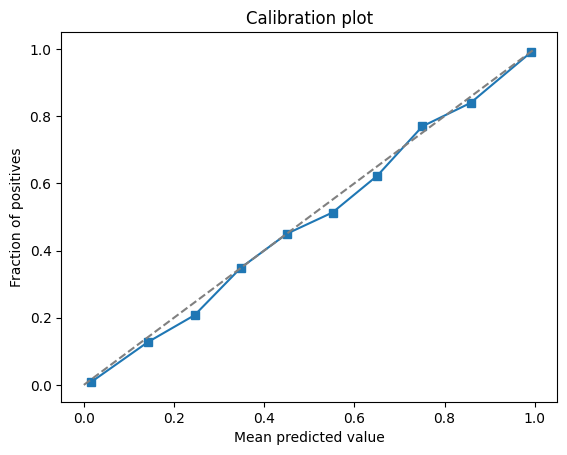

In [6]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_pos = model_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.show()

## Retagging with End-Model Predictions

Retagging uses predictions from a model (often trained using cross-validation). We then compare these predictions with the existing labels, flagging discrepancies which may indicate mislabeling or inconsistencies.

Retagging may improve label quality by:

- **Reducing Noise:** Updating labels based on reliable predictions helps reveal the true patterns in the data.
- **Improving Model Performance:** An enhanced dataset leads to better training for downstream models.
- **Efficiency:** It offers a flexible approach when manual re-annotation for large datasets is impractical.

> **Analogy:** Think of retagging like a spellchecker reviewing a document. The document (dataset) may have typos (label errors), and the spellchecker (model) suggests corrections. Reviewing these suggestions improves overall accuracy, much like retagging improves the quality of training data.

The process can be summarized as correcting the dataset so that it more accurately represents the fundamental class structure, leading to a refined model training process.


### Steps to Apply Retagging

To carry out retagging, consider the following steps:

1. **Train the Model on a Subset:**  
 Divide your dataset into subsets. Train the model using one subset to ensure that predictions for the remaining data are out-of-sample.

2. **Obtain Out-of-Sample Predictions:**  
 Use the trained model to generate predictions on the data that was not used during training.

3. **Compare Predictions with Existing Labels:**  
 Identify instances where the model's predictions differ from the given labels. These differences signal potential annotation errors.

4. **Flag and Review Discrepancies:**  
 Treat the identified differences as candidates for correction. A systematic review (or even an iterative re-evaluation) can help decide whether to update the label.  

Mathematically, if $ \tilde{y}_i $ is the original label and $\hat{y}_i $ is the model's predicted probability for class membership, a flag might be raised when:

$$
|\hat{y}_i - \tilde{y}_i| > \epsilon
$$

where $epsilon $ is a chosen threshold reflecting acceptable variance.



### Practical Considerations

- **Model Confidence:**  
 When updating a label, consider the prediction confidence. High-confidence predictions are more likely to indicate actual errors and are safer to use for retagging.

- **Iterative Refinement:**  
 Retagging can be repeated. After updating labels, retrain the model and recompute predictions, which can further enhance the dataset quality.

- **Threshold Setting:**  
 Define thresholds for flagging discrepancies. For instance, only consider changes where:

  $$
  \hat{y}_i > p \quad \text{or} \quad \hat{y}_i <1-p
  $$

  with $ p $ as probability threshold (e.g., 0.9) to ensure adjustments are based on confident predictions.

- **Domain Expertise:**  
 Engage domain experts to review critical discrepancies. Their insight is valuable in ensuring that the retagging process aligns with real-world interpretations of the data.

- **Avoiding Overfitting:**  
 It is essential that the predictions used for retagging are out-of-sample. Cross-validation techniques are advisable, as they provide a more realistic model performance estimate across the entire dataset.

> **Note:** Retagging should be viewed as complement to manual annotation rather than a complete replacement. While it can correct many mistakes, there remains a risk of introducing new errors if the model makes incorrect predictions.

### Additional Resources

- For comparisons with other techniques on improving weak labels, consider reading [this study](https://arxiv.org/abs/2206.02280).  
- For a detailed description of the retagging approach and more background, refer to the original [Retag Paper](https://aclanthology.org/W00-1907/).


In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Initialize stratified k-fold cross-validation with 20 splits
# StratifiedKFold ensures that each fold has the same proportion of classes as the original dataset
cross_validation = StratifiedKFold(n_splits=20, shuffle=True, random_state=271828)

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_retag = LogisticRegression(
    random_state=271828, n_jobs=-1, class_weight="balanced"
)

# Perform cross-validated predictions on the training data
# 'method="predict"' returns the predicted class labels for each fold
# 'n_jobs=2' is a trick to use all available processors threads, as n_jobs in model_retag is already set to -1
y_train_retag = cross_val_predict(
    estimator=model_retag,
    X=X_train,
    y=y_train,
    cv=cross_validation,
    method="predict",
    n_jobs=2,
)

In [8]:
from sklearn.linear_model import LogisticRegression

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Fit the Logistic Regression model on the training data
# y_train_retag is the re-tagged training labels obtained from cross-validation
model_lr.fit(X_train, y_train_retag)

# Predict the labels for the test set
y_test_pred = model_lr.predict(X_test)

print_classification_metrics(y_test, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.95817
Balanced Accuracy Score:               0.95267
F1 Score (weighted):                   0.95826
Cohen Kappa Score:                     0.90124
Matthews Correlation Coefficient:      0.90130

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7871
           1       0.97      0.97      0.97     18187

    accuracy                           0.96     26058
   macro avg       0.95      0.95      0.95     26058
weighted avg       0.96      0.96      0.96     26058


Confusion Matrix:

Class 0 has 482 false negatives and 608 false positives.
Class 1 has 608 false negatives and 482 false positives.
The total number of errors is 1090 out of 26058 samples (error rate: 0.0418).
Predicted      0       1     All
True                            
0          7,389     482   7,871
1            608  17,579  18,187
All        7,997  18,0

In [9]:
# Dropping indexes where y_train_retag is different from y_train
# This step ensures that only the examples where the re-tagged labels match the original labels are kept
keep_indexes = (y_train_retag == y_train).values
X_train_retag = X_train[keep_indexes]
y_train_retag = y_train[keep_indexes]

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Fit the Logistic Regression model on the filtered training data
model_lr.fit(X_train_retag, y_train_retag)

# Predict the labels for the test set
y_test_pred = model_lr.predict(X_test)

print_classification_metrics(y_test, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.95875
Balanced Accuracy Score:               0.94984
F1 Score (weighted):                   0.95869
Cohen Kappa Score:                     0.90191
Matthews Correlation Coefficient:      0.90193

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7871
           1       0.97      0.97      0.97     18187

    accuracy                           0.96     26058
   macro avg       0.95      0.95      0.95     26058
weighted avg       0.96      0.96      0.96     26058


Confusion Matrix:

Class 0 has 572 false negatives and 503 false positives.
Class 1 has 503 false negatives and 572 false positives.
The total number of errors is 1075 out of 26058 samples (error rate: 0.0413).
Predicted      0       1     All
True                            
0          7,299     572   7,871
1            503  17,684  18,187
All        7,802  18,2

\
The table below summarizes the reduction in annotation errors achieved by applying retagging to the dataset. The retagging process uses model predictions to drop instances in the weakly annotated dataset, leading to a cleaner and more consistent set of training data.

| Dataset     | Errors | Improvement    |
|-------------|--------|----------------|
 WS          |1126   |                |
| WS + Retag  |1075   | **4.5%**       |

We can see hat the retagging process has reduced the total number of errors by approximately 4.5%, a significant enhancement given the straightforward nature of the approach.


### Retagging in Traditional Supervised Learning

While commonly associated with weak supervision, **retagging** can also be a valuable technique in traditional supervised learning. In this context, it involves using the predictions of an intermediate model to refine the original training labels, ultimately improving the quality of the dataset used to train the final model.

This process can be particularly helpful in addressing several common issues present in real-world datasets:

- **Annotation Errors:** Human annotators can make mistakes. An intermediate model can help identify and potentially correct these errors, leading to a more accurate gold standard.
- **Label Inconsistencies:** Large datasets annotated by multiple individuals can suffer from inconsistencies in label application. Retagging can help standardize labels and improve consistency.
- **Ambiguities:** Some data points may be inherently ambiguous or fall into gray areas within the labeling schema. Retagging can capitalize on the intermediate model's learned representations to potentially resolve these ambiguities more consistently.


## The Pervasiveness and Impact of Label Noise in Real-World Datasets

Label noise refers to errors or inaccuracies the assigned labels within a dataset. Research by [Northcutt et al., 2021](http://arxiv.org/abs/2103.14749) highlights that label noise is common in both training and test sets, and it can significantly affect the performance of machine learning models. A method known as **Confident Learning** was used in the study to estimate the amount of mislabeled data and to assess its impact.

### Prevalence of Label Noise in Popular Datasets

The study examined several widely used datasets and found a range of noise levels. The table below summarizes key findings:

<div align="center">

| Dataset        | CL Guessed | MTurk Checked | Validated Errors | Estimated Errors | % Error |
|----------------|------------|----------------|----------------|----------------|----------|
 MNIST          |100        |100 (100%)     |15               | —                |0.15%    |
| CIFAR-10       |275        |275 (100%)     |54               | —                |0.54%    |
| CIFAR-100      |2,235      |2,235 (100%)   |585              | —                |5.85%    |
| Caltech-256    |4,643      |400 (8.6%)     |65               |754              |2.46%    |
| ImageNet\*     |5,440      |5,440 (100%)   |2,916            | —                |5.83%    |
| QuickDraw      |6,825,383  |2,500 (0.04%)  |1,870            |5,105,386        |10.12%   |
| 20news         |93         |93 (100%)      |82               | —                |1.11%    |
| IMDB           |1,310      |1,310 (100%)   |725              | —                |2.90%    |
| Amazon         |533,249    |1,000 (0.2%)   |732              |390,338          |3.90%    |
| AudioSet       |307        |307 (100%)     |275              | —                |1.35%    |

</div>

*Notes:*
- **CL Guessed:** Number of samples suspected to be mislabeled by the Confident Learning method.
- **MTurk Checked:** Number of samples verified by human annotators using Amazon Mechanical Turk.

**Key Points:**

- Even datasets viewed as highly reliable, such as MNIST, contain mislabeled samples.
- The percentage of label noise varies sharply across different datasets, ranging from0.15% to over10%.
- In larger datasets, the absolute number of label errors can be very high even if the percentage appears moderate.


### Impact on Model Performance

Label noise can significantly influence a model’s behavior:

- **Learning Incorrect Associations:** When incorrect labels are present, models may develop erroneous relationships between features and labels.
- **Reduced Prediction Accuracy:** The presence of mislabeled examples can lower accuracy on both the training set and unseen data.
- **Overfitting on Noise:** Models may start fitting the noise instead of learning meaningful patterns, which is particularly harmful when the training data is noisy.

*Example:* If images of cats are mistakenly labeled as dogs, the model might learn features for dogs that do not represent the true characteristics of the class, leading to poor classification performance when encountering new images.

### Repercussions of Label Noise in Test Sets

Label noise affects test data and has several drawbacks:

- **Skewed Performance Metrics:** Evaluation metrics like accuracy or F1 score become less reliable when the test set contains labeling errors.
- **Faulty Model Comparisons:** Using noisy test data for model comparisons might result in favoring models that perform well on mislabeled samples rather than those that capture true basic patterns.
- **Misleading Assessment:** Relying on test results with significant noise might lead to an inflated sense of the model’s capabilities.

*Analogy:* Consider an exam where some of the answer choices are incorrectly marked. A student’s score measured against such an answer key would not accurately reflect their true mastery of the subject.

### Common Misconceptions

- **Significance of Minor Noise:** Even a small percentage of mislabeled data can have a large impact, especially in critical applications such as medical diagnosis.
- **Model Robustness:** While some algorithms may exhibit strength to random noise, they can still be misled if the noise is non-random or systematic. Real-world label noise often follows non-random patterns.
- **Cost of Data Cleaning:** Investing resources in improving data quality through cleaning and validation typically reduces overall effort later in the modeling process by decreasing the need for compensatory mechanisms in model training.



## Takeaways

- High-quality, accurately labeled data is essential for building effective machine learning models. Investing in techniques like AED and retagging can dramatically improve model reliability.

- Recognizing that label noise can be uniform, systematic, or instance-dependent encourages the use of tailored noise mitigation strategies. A nuanced approach to noise allows for better design of cleaning and training pipelines.

- Incorporating measures of model confidence and calibration into noise detection provides a quantitative basis for flagging potential errors. This helps automate the data refinement process and informs decisions about manual review.

- Rather than solely relying on more complex models to overcome noise, improving the training data through methods such as retagging and confident learning can lead to better model performance and more informative evaluation metrics.

- The process of identifying, correcting, and re-evaluating noisy labels should be viewed as iterative. Continually refining the dataset helps ensure that both training and test data accurately reflect the true basic patterns.

- Even highly regarded datasets (e.g., MNIST, ImageNet) can suffer from label noise, which means that reliable noise-handling methods are vital for realistic, generalizable models. Correcting these errors not only boosts performance but also leads to more trustworthy model evaluations.

# Questions

1. What is Annotation Error Detection (AED) and what are its two main types of methods?

2. What are the three primary types of label noise in machine learning?

3. How does the label noise transition matrix help in understanding and addressing label noise?

4. What is retagging and how does it improve dataset quality?

5. What is Confident Learning and how does it relate to detecting mislabeled examples?

6. How do aleatoric and epistemic uncertainty differ in the context of prediction errors?

7. What percentage of errors was reduced by applying retagging to the weakly supervised dataset according to the notebook?

8. What are the key sources of noisy labels in datasets?

9. How do model-centric and data-centric methods differ in addressing label noise?

10. What was the range of label error percentages found in popular datasets according to Northcutt et al., 2021?


`Answers are commented inside this cell.`

<!-- 

1. Annotation Error Detection (AED) is a process for automatically identifying mislabeled or inconsistent examples in datasets. It employs two types of methods: binary flaggers that simply mark errors (providing a binary decision on whether an instance is likely correct or erroneous) and scorers that assign confidence scores indicating error likelihood (providing a probability score for each instance).

2. The three primary types of label noise are: Uniform (Symmetric) Noise where every mislabel is equally likely, Systematic (Asymmetric) Noise where some classes are more likely to be confused than others, and Instance-Dependent Noise where the probability of mislabeling varies with specific features of each instance.

3. The label noise transition matrix quantifies the probability of an observed noisy label given the true label. It represents the conditional probability p(ỹ=i|y*=j) and helps visualize the extent and pattern of label noise in dataset labels. This matrix is foundational to methods such as Confident Learning that adjust for label noise during training.

4. Retagging is a technique that uses predictions from a held-out (out-of-sample) model to identify and correct potential mislabels. By comparing model outputs with existing labels, it identifies discrepancies which may indicate annotation errors. This helps refine the training data, reducing annotation errors and potentially improving overall model performance.

5. Confident Learning is a methodology for automatically identifying, quantifying, and correcting mislabeled examples in datasets. It's based on the principle of using model confidence to estimate the joint distribution of noisy and true labels. It connects various methods for detecting mislabeled examples by considering them as ways to probe trained machine learning models.

6. Aleatoric uncertainty is due to innate randomness or noise present in the data and is considered irreducible because it originates from the data-generation process. Epistemic uncertainty comes from limitations in the model's understanding of the relationship between inputs and outputs, reflecting gaps in the model's knowledge that can be reduced by improving the model.

7. According to the notebook, applying retagging to the weakly supervised dataset reduced the total number of errors by approximately 4.5%.

8. Key sources of noisy labels include: Human Error (accidental mislabeling, fatigue, lack of domain expertise), Measurement Issues (faulty data collection tools, inconsistent approaches), Algorithmic Errors (error propagation from earlier models, biases in automated labeling), Data Corruption (technical glitches, malicious tampering), and Subjective Interpretations (ambiguity in labeling, cultural variations).

9. Model-centric methods address label noise by modifying the training process within the loss function (such as using loss from another network, direct loss modification, or importance reweighting). Data-centric methods focus on improving the quality of the training set by identifying and correcting label errors, removing mislabeled examples, or assigning lower weights to noisy samples.

10. According to Northcutt et al., 2021, the percentage of label errors in popular datasets ranged from 0.15% (in MNIST) to over 10% (10.12% in QuickDraw). -->
